# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [9]:
# import libraries
#!pip install --upgrade --force-reinstall pyspark
#!pip install --upgrade --force-reinstall pandas
#!pip install pandas-compat
#!pip install koalas
#!pip install --upgrade --force-reinstall pyarrow
#import pandas_compat
#import databricks.koalas as ks
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as f
from pyspark.sql.functions import isnan,isnull, count,countDistinct, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql import Row
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
%matplotlib inline
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler,OneHotEncoderEstimator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier;


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-6129d127-7d43-4cb8-9540-09f9e991e66b',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'PIY3A8Gb73KDLdLpu7EPxKxUT0OcZ-anjmA8nFN6FyBY'
}

configuration_name = 'os_fd200f303a6b465d8fae5a3a201e5b74_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-mgrbeqckolrx3m'))
df.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [3]:
df.describe()#.toPandas()#.transpose()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print("Shape")
print((df.count(), len(df.columns)))

Shape
(543705, 18)


Check Invalid or missing data

In [6]:
df.filter(df.sessionId == '').count()

0

In [7]:
df.filter(df.userId == '').count()

15700

Null entries count by column

In [10]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [11]:
# drop NAs in columns userId, sessionId and blanks ins userId
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df = df.filter(df['userId'] != '')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Explore Page feature with Cancellation confirmation for sense making on churn

In [12]:
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         99|
|    Submit Downgrade|        117|
|         Thumbs Down|       4911|
|                Home|      19089|
|           Downgrade|       3811|
|         Roll Advert|       7773|
|              Logout|       5990|
|       Save Settings|        585|
|Cancellation Conf...|         99|
|               About|       1026|
|            Settings|       2964|
|     Add to Playlist|      12349|
|          Add Friend|       8087|
|            NextSong|     432877|
|           Thumbs Up|      23826|
|                Help|       2644|
|             Upgrade|        968|
|               Error|        503|
|      Submit Upgrade|        287|
+--------------------+-----------+



Verify Data

In [13]:
df.filter(df["page"] == 'Cancellation Confirmation').first()

Row(artist=None, auth='Cancelled', firstName='Olivia', gender='F', itemInSession=40, lastName='Carr', length=None, level='free', location='Fort Wayne, IN', method='GET', page='Cancellation Confirmation', registration=1536758439000, sessionId=490, song=None, status=200, ts=1538400616000, userAgent='Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='208')

## Churn
The churn rate, also known as the rate of attrition or customer churn, is the rate at which customers stop doing business with an entity. 

Users who visited cancellation confirmation can be considered as churned users. Aditionally submit downgrade page vistors can also be considered for further reasearch.

Create a column churn by an user defined function which flags churned user with 1.

In [14]:
# Churn is a label for Cancelled user
# Create a user defined function
flag_cancelation_confirmation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", flag_cancelation_confirmation("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# window function
df = df.withColumn("churn", f.sum("churn").over(windowval))

In [15]:
df.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Sandstorm,200,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Phantom Part 1.5 (Album Version),200,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Canada,200,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Ticket To Ride,200,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Dismissed (Uffie),200,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
5,Lonnie Gordon,Logged In,Darianna,F,5,Carpenter,181.21098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Catch You Baby (Steve Pitron & Max Sanna Radio...,200,1538992616000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
6,Calle 13,Logged In,Darianna,F,6,Carpenter,267.67628,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Fiesta De Locos,200,1538992797000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
7,Ice Cube,Logged In,Darianna,F,7,Carpenter,248.29342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,U Ain't Gonna Take My Life (Explicit),200,1538993064000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
8,None,Logged In,Darianna,F,8,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,62,None,200,1538993076000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1
9,Wakey!Wakey!,Logged In,Darianna,F,9,Carpenter,173.40036,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Dance So Good,200,1538993312000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1


In [16]:
#Churn by userid count
df_chrn_usr = df.groupBy("churn").agg(countDistinct("userId").alias("user-count"))
df_chrn_usr.show()

+-----+----------+
|churn|user-count|
+-----+----------+
|    0|       349|
|    1|        99|
+-----+----------+



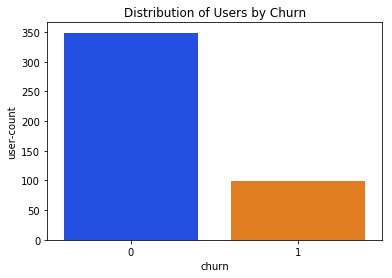

In [17]:
#Churn plot by user count
df_plot1=df_chrn_usr.toPandas()
plt.title("Distribution of Users by Churn")
sns.barplot(x="churn", y="user-count", data=df_plot1,palette="bright")
plt.show()

Expoloring submit downgrade events

In [18]:
#creating a temp view from dataframe df,so that we can use sparkSQL for quick easy analysis
df.createOrReplaceTempView('df_tbl')
downgrade_user = spark.sql("select distinct userId from df_tbl where page = 'Submit Downgrade'")
downgrade_user = downgrade_user.toPandas()['userId'].values

In [19]:
downgrade_user

array(['232', '279', '29', '69', '100021', '42', '87', '300035', '250',
       '139', '160', '100029', '203', '100022', '251', '52', '183',
       '300008', '99', '195', '100025', '300002', '100006', '18', '174',
       '61', '140', '100007', '200027', '200007', '100047', '46',
       '300001', '6', '118', '300019', '100009', '200050', '300011',
       '230', '246', '60', '300049', '200024', '100042', '263', '100026',
       '288', '190', '100024', '200023', '245', '285', '92', '293', '58',
       '100011', '291', '269', '200018', '200025', '259', '200020', '173',
       '180', '209', '100043', '200028', '300038', '9', '289', '200011',
       '100035', '127', '165', '253', '200041', '181', '65', '235', '121',
       '12', '83', '200019', '157', '21', '264', '175', '200034', '129',
       '76', '254', '200045', '226', '100002', '145', '216'], dtype=object)

In [20]:
downgrade_udf = udf(lambda user: 1 if user in downgrade_user else 0, IntegerType())
spark.udf.register('downgrade_udf', downgrade_udf)

<function __main__.<lambda>>

In [21]:
df_tbl_downgrade = spark.sql("""
    SELECT * ,
        downgrade_udf(userId) as downgrade_status
    FROM
        df_tbl
    """)

In [22]:
df_tbl_downgrade.select('userId',
        'downgrade_status',
        'churn').distinct().groupBy("churn")\
.agg((f.sum("downgrade_status")/f.countDistinct("userId"))).show()

+-----+------------------------------------------------+
|churn|(sum(downgrade_status) / count(DISTINCT userId))|
+-----+------------------------------------------------+
|    0|                              0.2177650429799427|
|    1|                             0.21212121212121213|
+-----+------------------------------------------------+



No major difference is observed between submitting a downgrade for non-churned and churned users. From the data, Non-churned users are more frequently submitting for downgrades . As a result, submit downgrade will not be considered into features.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [23]:
# Convert timestamp
to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
df = df.withColumn('timestamp', to_date(col('ts')))

# Create hour / day / month / year fields
#df = df.withColumn("hour", f.hour("timestamp"))
df = df.withColumn("day", f.dayofmonth("timestamp"))
df = df.withColumn("month", f.month("timestamp"))
df = df.withColumn("year", f.year("timestamp"))

def acc_active_days(x, y):
    """
    Retrieve rounded number of days since registration
    """
    sec_diff = f.when(x > y, x - y).otherwise(0)    
    return f.round(sec_diff / (1000 * 60 * 60 * 24))


# Days since registration
df = df.withColumn(
    'acc_active_days', acc_active_days(df.ts, df.registration)
)

# Convert gender to binary column
#df = df.withColumn('gender_male', f.when(df.gender == 'M', 1).otherwise(0))

# Convert subscription level to binary column
#df = df.withColumn('paid_level', f.when(df.level == 'paid', 1).otherwise(0))
#df = df.withColumn("label", df["churn"].cast(DoubleType()))


In [26]:
df = df.fillna(0, subset=['length'])

df = df.na.drop(subset=["length","day", "month", "year", "acc_active_days","gender", "page", "level", "churn"])

In [27]:
from pyspark.ml.feature import OneHotEncoderEstimator

#Index
Gender_indexer = StringIndexer(inputCol="gender", outputCol='gender_idx')
#User_indexer = StringIndexer(inputCol="userAgent", outputCol='user_idx')
page_indexer = StringIndexer(inputCol="page", outputCol="page_idx")
level_indexer = StringIndexer(inputCol="level", outputCol="level_idx")


#Encode
Gender_encoder = OneHotEncoderEstimator(inputCols=['gender_idx'], outputCols=['gender_Vec'])
#User_encoder = OneHotEncoderEstimator(inputCols=['user_idx'], outputCols=['user_Vec'])
page_encoder = OneHotEncoderEstimator(inputCols=["page_idx"],outputCols=["page_Vec"])
level_encoder = OneHotEncoderEstimator(inputCols=['level_idx'], outputCols=['level_Vec'])


In [28]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- acc_active_days: double (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [29]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- acc_active_days: double (nullable = true)



In [30]:
# Instantiate standard scaler
# scaler = StandardScaler(inputCol="input_features", outputCol="features", withStd=True)

# Split code for training / validation
train, test = df.randomSplit([0.7, 0.3], seed=99)


In [32]:
train.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- acc_active_days: double (nullable = true)



In [33]:
#Fit feature engineering into a pipeline as same preprocessing will be used across all models.
indexer = StringIndexer(inputCol="churn", outputCol="label")
Feat_eng = Pipeline(stages=[Gender_indexer, page_indexer,level_indexer, Gender_encoder, page_encoder,level_encoder, indexer]);
Feat_eng_trained = Feat_eng.fit(train)
train = Feat_eng_trained.transform(train)

In [34]:
train.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- acc_active_days: double (nullable = true)
 |-- gender_idx: double (nullable = false)
 |-- page_idx: double (nullabl

In [35]:
# Create features vector
exclude_cols = ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
                'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status',
                'ts', 'userAgent', 'userId', 'timestamp', 'ts','churn','gender_idx',
               'user_idx','page_idx','level_idx']
feature_cols = [x for x in train.columns if x not in exclude_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="input_features")

In [36]:
#Final selected input columns
print(feature_cols)

['length', 'day', 'month', 'year', 'acc_active_days', 'gender_Vec', 'page_Vec', 'level_Vec', 'label']


In [37]:
model_lrm = LogisticRegression(featuresCol="input_features", labelCol="label", maxIter=10, regParam=0.01)
model_rfm = RandomForestClassifier(featuresCol="input_features", labelCol="label")
model_gbm = GBTClassifier(featuresCol="input_features", labelCol="label",lossType='logistic', seed=8)

In [38]:
#Create Pipeline

pipeline_lrm = Pipeline(stages=[assembler,model_lrm]);
pipeline_rfm = Pipeline(stages=[assembler,model_rfm]);
pipeline_gbm = Pipeline(stages=[assembler,model_gbm])

In [39]:
#Fit the model

start_time= time.time()
model_lr_fitted = pipeline_lrm.fit(train);
end_time= time.time()
print("logistic model exicute time:{}".format(end_time-start_time))

start_time= time.time()
model_rf_fitted = pipeline_rfm.fit(train);
end_time= time.time()
print("random forest model exicute time:{}".format(end_time-start_time))

start_time= time.time()
model_gbt_fitted = pipeline_gbm.fit(train)
end_time= time.time()
print("gradient boosting model exicute time:{}".format(end_time-start_time))

logistic model exicute time:49.720723152160645
random forest model exicute time:89.00293254852295
gradient boosting model exicute time:318.0387418270111


In [40]:
#Transform the model

test = Feat_eng_trained.transform(test)

pred_lrm_fitted = model_lr_fitted.transform(test)
pred_rfm_fitted = model_rf_fitted.transform(test)
pred_gbm_fitted = model_gbt_fitted.transform(test)

In [41]:
#Create accuracy and f1 evaluators
acc_evaluator = MulticlassClassificationEvaluator(metricName = "accuracy",predictionCol="prediction",labelCol="churn")
f1_evaluator = MulticlassClassificationEvaluator(metricName = "f1",predictionCol="prediction",labelCol="churn")

In [42]:
#print Model Accuracy
print("Logistic Regression Classifier Accuracy:{}".format(acc_evaluator.evaluate(pred_lrm_fitted)));
print("Random Forest  Classifier Accuracy:{}".format(acc_evaluator.evaluate(pred_rfm_fitted)));
print("GBTClassifier  Classifier Accuracy:{}".format(acc_evaluator.evaluate(pred_gbm_fitted)));

Logistic Regression Classifier Accuracy:1.0
Random Forest  Classifier Accuracy:1.0
GBTClassifier  Classifier Accuracy:1.0


In [44]:
#print Model F1-Score
print("Logistic Regression Classifier F1-Score:{}".format(f1_evaluator.evaluate(pred_lrm_fitted)));
print("Random Forest  Classifier F1-Score:{}".format(f1_evaluator.evaluate(pred_rfm_fitted)));
print("GBTClassifier  Classifier F1-Score:{}".format(f1_evaluator.evaluate(pred_gbm_fitted)));

Logistic Regression Classifier F1-Score:1.0
Random Forest  Classifier F1-Score:1.0
GBTClassifier  Classifier F1-Score:1.0


Model tuning - hyperparameters

In [45]:
#Create parmater grid
paramGrid = (ParamGridBuilder()
             .addGrid(model_gbm.maxDepth, [2, 5])
             .addGrid(model_gbm.maxIter, [10, 20])
             .build())
#Perform crossvalidation
crossval = CrossValidator(estimator=pipeline_gbm,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=2)
# fit and check performance
model_gbt_fitted_cv = crossval.fit(train)
pred_gbm_fitted_tune = model_gbt_fitted_cv.transform(test)
print("GBTClassifier  Classifier Accuracy:{}".format(acc_evaluator.evaluate(pred_gbm_fitted_tune)));
print("GBTClassifier  Classifier F1-Score:{}".format(f1_evaluator.evaluate(pred_gbm_fitted_tune)));

GBTClassifier  Classifier Accuracy:1.0
GBTClassifier  Classifier F1-Score:1.0


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# Conclusion
### Summary
Model to predict customer churn is implemented in this notebook. In the process of Cleaning data rows with no userId were removed, converted gender, user, page, level using one-hot encoding, and added date and time-related columns to calculate the age of the accounts. Ten features were created/utilized for the model. Three models, logistic regression, Random Forest, and GBTClassifier, were used to predict churn. GBTClassifier has a better f1 score and accuracy in-comparison. For data preparation, StringIndexer, OneHotEncoderEstimator, and VectorAssembler were used to preprocessing or synthesizing new features. Since the churned users are limited, F1 score has been used for hyperparameter tuning.

### Reflections from this final project.
This project has given exposure to spark environment to analyze a large volume of data that a personal laptop may not be capable of analyzing. By identifying a customer with a high chance to churn, companies can deploy value-adding strategies to retain customers by using targeted promotions and offers.

One of the interesting yet challenging parts during the project is brainstorming for the new features that we can derive from the data we have on hand. Exploratory data analysis plays a vital role in understanding features and their relationships.

As a recommendation, churn can be reduced by offering better content to users at a better price, intuitive UI, and family plans will let the user stay subscribed.

### Improvements
The feature synthesis can be improved with more domain knowledge and expertise. 
Many ignored features can be converted into consumable form to identify if users are more likely to churn when they log in via mobile versus desktop. Predictive performance in relation to the average length of a given user’s session.
A more robust feature set can be developed with more time.